In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
data = np.loadtxt('../Data_USL/s3.txt')

# K-Means

In [3]:
def kmeans(data, k, max_iter=300):
    # data -> array of data points
    # k -> number of clusters/centroids
    n_points = data.shape[0]
    tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
    init_positions = tmp_arr.copy()
    
    for i in range(max_iter):
        dist_sq = distance.cdist(data,init_positions,'sqeuclidean')
        dist_sq_min = np.array([np.min(dist_sq, axis=1)])
        labels = np.argmin(dist_sq, axis=1)
        total_loss = dist_sq_min.sum()
        flag = False
        
        for j in range(k):
            if len(data[labels==j]) == 0:
                flag = True
        
        if flag == True:
            tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
            init_positions = tmp_arr.copy()
            continue
        
        new_positions = np.array([data[labels==l].mean(axis=0) for l in range(k)])    
                
        if np.all(init_positions == new_positions):
            break
        
        init_positions = new_positions
        
    #print("Reached Maximum Number of Iterations")
    return total_loss, i, labels, new_positions

In [4]:
def cluster_plot(data,k,labels,centroid_positions):
    n_points = data.shape[0]
    plt.figure(figsize=(7,5))
    for i in range(k):
        array = data[labels==i]
        plt.scatter(array[:,0],array[:,1],s=4)
    plt.scatter(centroid_positions[:,0],centroid_positions[:,1],s=12,c='k')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [5]:
%%time
loss_val, iter_, labels, centroid_positions = kmeans(data,15)
print(loss_val, iter_)

20707352226685.266 28
CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 93.1 ms


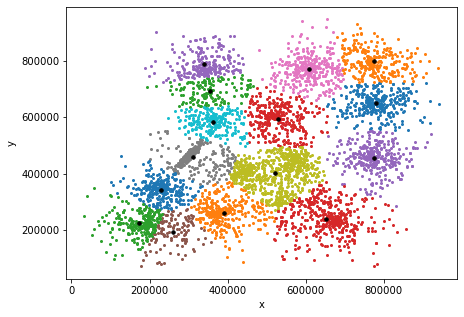

In [6]:
cluster_plot(data,15,labels,centroid_positions)

### Objective function for k = 15, n = 100

Average Loss: 19633606073421.914
Minimum Loss: 16889783535768.902


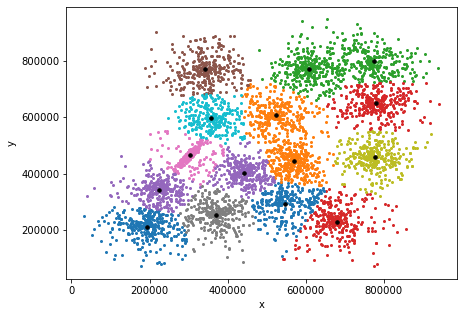

CPU times: user 8.49 s, sys: 273 µs, total: 8.49 s
Wall time: 8.49 s


In [7]:
%%time
k = 15
n_iter = 100
min_loss_val = +np.inf
loss_vals = np.zeros(n_iter)

for i in range(n_iter):
    loss_val, iter_, labels, centroid_positions = kmeans(data,k)
    if loss_val < min_loss_val:
        min_loss_val = loss_val
        best_centroid_positions = centroid_positions
        best_labels = labels
    loss_vals[i] = loss_val
    
print("Average Loss:", loss_vals.mean())
print("Minimum Loss:", loss_vals.min())

cluster_plot(data,15,best_labels,best_centroid_positions)   

### Scree Test for K-Means for best value of loss function

K = 2, Average Loss: 210428334804957.47, Minimum Loss: 210428334804957.56
K = 3, Average Loss: 144111638404301.8, Minimum Loss: 139614749639647.7
K = 4, Average Loss: 91771699756784.02, Minimum Loss: 91771622303874.1
K = 5, Average Loss: 76099041558728.31, Minimum Loss: 75054113455106.05
K = 6, Average Loss: 63801089746139.31, Minimum Loss: 61402015734903.92
K = 7, Average Loss: 52894854776482.83, Minimum Loss: 50219462491968.78
K = 8, Average Loss: 44246313281129.41, Minimum Loss: 42058196688047.5
K = 9, Average Loss: 37696122095145.69, Minimum Loss: 36048589584476.06
K = 10, Average Loss: 32961651621765.34, Minimum Loss: 30332860333232.836
K = 11, Average Loss: 28347487588781.336, Minimum Loss: 27297326282979.555
K = 12, Average Loss: 25715317353891.605, Minimum Loss: 24424352971933.688
K = 13, Average Loss: 23204769886201.547, Minimum Loss: 21767253017798.883
K = 14, Average Loss: 21050906505686.375, Minimum Loss: 19211020216301.234
K = 15, Average Loss: 19727313020756.6, Minimum Lo

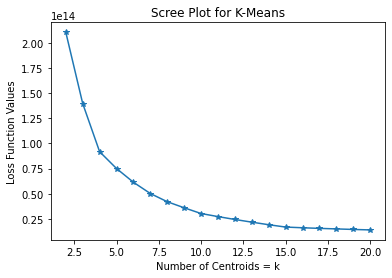

CPU times: user 1min 54s, sys: 1.96 ms, total: 1min 54s
Wall time: 1min 54s


In [8]:
%%time

n_iter = 100
min_k = 2
max_k = 21
scree_vals = np.empty((max_k-min_k,2))

for count,k in enumerate(range(min_k,max_k)):
    min_loss_val = +np.inf
    loss_vals = np.zeros(n_iter)

    for i in range(n_iter):
        loss_val, _, _, _ = kmeans(data,k)
        if loss_val < min_loss_val:
            min_loss_val = loss_val
        loss_vals[i] = loss_val
    
    print("K = {0}, Average Loss: {1}, Minimum Loss: {2}"
          .format(k, loss_vals.mean(), loss_vals.min()))
    
    scree_vals[count,0] = k
    scree_vals[count,1] = loss_vals.min()
    
plt.title("Scree Plot for K-Means")
plt.ylabel("Loss Function Values")
plt.xlabel("Number of Centroids = k")
plt.plot(scree_vals[:,0],scree_vals[:,1],'*-')
plt.show()

# K-Means ++

In [9]:
def kmeans_pp_init(data, k):
    centroids = data[np.random.choice(data.shape[0],1,replace=False)] # chosen randomly to start with
    kmpp_init_centroids = np.empty((k, data.shape[1]))
    kmpp_init_centroids[0] = centroids
    for i in range(1,k):
        dist_sq = distance.cdist(data, centroids, 'sqeuclidean')
        probability = np.squeeze(dist_sq/np.sum(dist_sq))
        new_centroid = data[np.random.choice(data.shape[0], 1, replace=False, p=probability)]
        
        if new_centroid in kmpp_init_centroids:
            i = i - 1 # choose new centroid and repeat this iteration
        else:
            kmpp_init_centroids[i] = new_centroid.copy()
            centroids = new_centroid.copy()
        
    return kmpp_init_centroids

In [10]:
def kmeans_pp(data, k, max_iter=300):
    # data -> array of data points
    # k -> number of clusters/centroids
    n_points = data.shape[0]
    
    # Here, we initialize differently for KMeans++
    #tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
    #init_positions = tmp_arr.copy()
    init_positions = kmeans_pp_init(data,k) 
        
    for i in range(max_iter):
        dist_sq = distance.cdist(data,init_positions,'sqeuclidean')
        dist_sq_min = np.array([np.min(dist_sq, axis=1)])
        labels = np.argmin(dist_sq, axis=1)
        total_loss = dist_sq_min.sum()
        flag = False
        
        for j in range(k):
            if len(data[labels==j]) == 0:
                flag = True
        
        if flag == True:
            tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
            init_positions = tmp_arr.copy()
            continue
        
        new_positions = np.array([data[labels==l].mean(axis=0) for l in range(k)])    
                
        if np.all(init_positions == new_positions):
            break
        
        init_positions = new_positions
        
    #print("Reached Maximum Number of Iterations")
    return total_loss, i, labels, new_positions

In [11]:
%%time
loss_val, iter_, labels, centroid_positions = kmeans_pp(data,15)
print(loss_val, iter_)

18803346353138.72 14
CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 103 ms


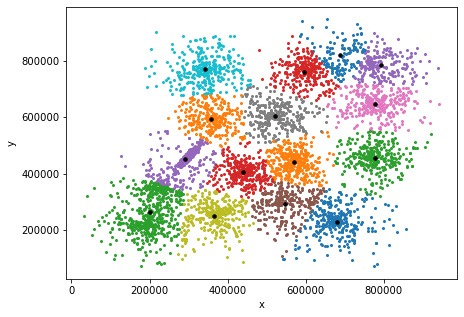

In [12]:
cluster_plot(data,15,labels,centroid_positions)

### Objective function for k = 15, n = 100

Average Loss: 19405310126088.523
Minimum Loss: 16889808843401.277


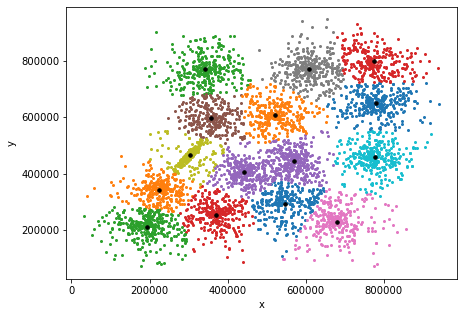

CPU times: user 8.5 s, sys: 12 ms, total: 8.51 s
Wall time: 8.51 s


In [13]:
%%time
k = 15
n_iter = 100
min_loss_val = +np.inf
loss_vals = np.zeros(n_iter)

for i in range(n_iter):
    loss_val, iter_, labels, centroid_positions = kmeans_pp(data,k)
    if loss_val < min_loss_val:
        min_loss_val = loss_val
        best_centroid_positions = centroid_positions
        best_labels = labels
    loss_vals[i] = loss_val
    
print("Average Loss:", loss_vals.mean())
print("Minimum Loss:", loss_vals.min())

cluster_plot(data,15,best_labels,best_centroid_positions)   

### Scree Test for K-Means ++ for best value of loss function

K = 2, Average Loss: 210428334804957.47, Minimum Loss: 210428334804957.56
K = 3, Average Loss: 145757598436187.56, Minimum Loss: 139614749639647.7
K = 4, Average Loss: 92235645171261.19, Minimum Loss: 91771622303874.1
K = 5, Average Loss: 76048982599707.11, Minimum Loss: 75054113455106.05
K = 6, Average Loss: 63094877465215.81, Minimum Loss: 61401881375290.59
K = 7, Average Loss: 52681464612274.88, Minimum Loss: 50219935269293.875
K = 8, Average Loss: 43886051040282.06, Minimum Loss: 42058196688047.5
K = 9, Average Loss: 37378715353562.305, Minimum Loss: 36048589584476.06
K = 10, Average Loss: 31791011076215.875, Minimum Loss: 30332860333232.836
K = 11, Average Loss: 28079806970970.047, Minimum Loss: 27297261642228.04
K = 12, Average Loss: 25317624424771.664, Minimum Loss: 24424381331165.88
K = 13, Average Loss: 22643043762747.684, Minimum Loss: 21767246387145.258
K = 14, Average Loss: 20976958073652.28, Minimum Loss: 19210855194120.21
K = 15, Average Loss: 19333533733070.24, Minimum L

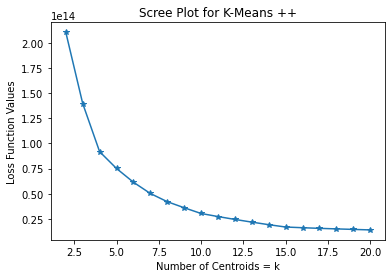

CPU times: user 3min 8s, sys: 116 ms, total: 3min 9s
Wall time: 3min 9s


In [14]:
%%time

n_iter = 100
min_k = 2
max_k = 21
scree_vals = np.empty((max_k-min_k,2))

for count,k in enumerate(range(min_k,max_k)):
    min_loss_val = +np.inf
    loss_vals = np.zeros(n_iter)

    for i in range(n_iter):
        loss_val, _, _, _ = kmeans_pp(data,k)
        if loss_val < min_loss_val:
            min_loss_val = loss_val
        loss_vals[i] = loss_val
    
    print("K = {0}, Average Loss: {1}, Minimum Loss: {2}"
          .format(k, loss_vals.mean(), loss_vals.min()))
    
    scree_vals[count,0] = k
    scree_vals[count,1] = loss_vals.min()
    
plt.title("Scree Plot for K-Means ++")
plt.ylabel("Loss Function Values")
plt.xlabel("Number of Centroids = k")
plt.plot(scree_vals[:,0],scree_vals[:,1],'*-')
plt.show()

# Fuzzy C-Means

In [15]:
def cmeans(data,k,m=2,eps=1.e-5,max_iter=300):
    # m is fuzzification parameter, usually = 2
    # k -> number of clusters/centroids
    n_points = data.shape[0]
    u = np.random.random((n_points,k))
    diff_u = np.ones((n_points, k))
    u = u / np.sum(u,axis=1)[:,np.newaxis]
    counter = 0
    while np.max(diff_u) > eps:
        counter += 1
        centroid_positions = np.dot(u.T**m,data)/np.sum(u.T**m, axis=1)[:,np.newaxis]
        u_new = 1/((distance.cdist(data, centroid_positions)/
                    np.sum(distance.cdist(data, centroid_positions), axis=1)[:,np.newaxis])**(2/(m-1)))
        u_new = u_new / np.sum(u_new,axis=1)[:,np.newaxis]
        diff_u = np.abs(u_new - u)
        u = u_new.copy()
        total_loss = np.sum((distance.cdist(data, centroid_positions, metric='sqeuclidean'))*(u**m))
        labels = np.argmax(u, axis=1)
    return total_loss, counter, labels, centroid_positions

In [16]:
%%time

loss_val, iter_, labels, centroid_positions = cmeans(data, 15)
print(loss_val, iter_)

8572169623519.224 160
CPU times: user 3.7 s, sys: 32 ms, total: 3.74 s
Wall time: 936 ms


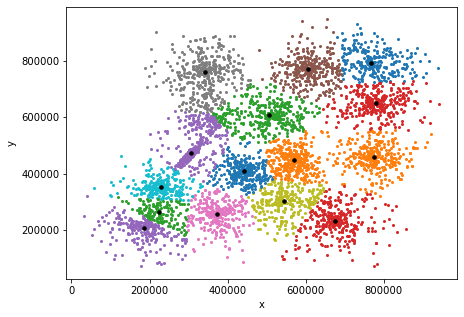

In [17]:
cluster_plot(data,15,labels,centroid_positions)

### Assignation for best case (k=15)

Average Loss: 8247778903947.406
Minimum Loss: 7988108819363.252


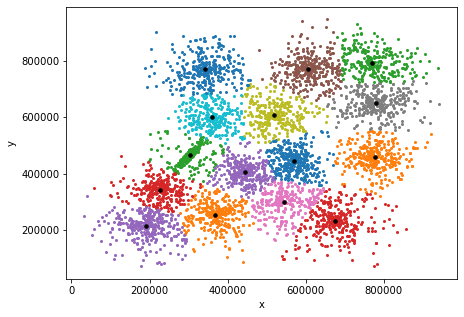

CPU times: user 2min 57s, sys: 2.49 s, total: 2min 59s
Wall time: 45.1 s


In [18]:
%%time
k = 15
n_iter = 100
min_loss_val = +np.inf
loss_vals = np.zeros(n_iter)

for i in range(n_iter):
    loss_val, iter_, labels, centroid_positions = cmeans(data,k)
    if loss_val < min_loss_val:
        min_loss_val = loss_val
        best_centroid_positions = centroid_positions
        best_labels = labels
    loss_vals[i] = loss_val
    
print("Average Loss:", loss_vals.mean())
print("Minimum Loss:", loss_vals.min())

cluster_plot(data,15,best_labels,best_centroid_positions)   

### Scree Plot for Fuzzy CMeans for best value of loss function

K = 2, Average Loss: 154248968481415.53, Minimum Loss: 154248968463544.0
K = 3, Average Loss: 90622636191040.88, Minimum Loss: 90622636178175.53
K = 4, Average Loss: 58128291367753.8, Minimum Loss: 58128291364590.82
K = 5, Average Loss: 43719561829966.53, Minimum Loss: 43719561828034.71
K = 6, Average Loss: 33740673789798.203, Minimum Loss: 33658231128860.957
K = 7, Average Loss: 26907946841223.73, Minimum Loss: 26723405762604.004
K = 8, Average Loss: 22071073669625.832, Minimum Loss: 21845266546449.336
K = 9, Average Loss: 18297023286454.1, Minimum Loss: 18032847932984.613
K = 10, Average Loss: 15589855523267.578, Minimum Loss: 15270663058400.879
K = 11, Average Loss: 13507411436089.096, Minimum Loss: 13353942117290.947
K = 12, Average Loss: 11832660429252.207, Minimum Loss: 11631858697735.193
K = 13, Average Loss: 10426129607708.111, Minimum Loss: 10160937291404.252
K = 14, Average Loss: 9179519514333.24, Minimum Loss: 8985554937495.031
K = 15, Average Loss: 8230043233664.836, Minimu

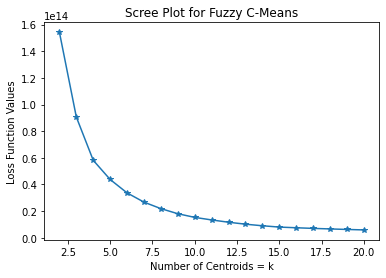

CPU times: user 1h 42min 21s, sys: 1min 26s, total: 1h 43min 47s
Wall time: 26min 11s


In [19]:
%%time

n_iter = 10 # reduce this from 100 to 10 otherwise it takes way too long to run
min_k = 2
max_k = 21
scree_vals = np.empty((max_k-min_k,2))

for count,k in enumerate(range(min_k,max_k)):
    min_loss_val = +np.inf
    loss_vals = np.zeros(n_iter)

    for i in range(n_iter):
        loss_val, _, _, _ = cmeans(data,k)
        if loss_val < min_loss_val:
            min_loss_val = loss_val
        loss_vals[i] = loss_val
    
    print("K = {0}, Average Loss: {1}, Minimum Loss: {2}"
          .format(k, loss_vals.mean(), loss_vals.min()))
    
    scree_vals[count,0] = k
    scree_vals[count,1] = loss_vals.min()
    
plt.title("Scree Plot for Fuzzy C-Means")
plt.ylabel("Loss Function Values")
plt.xlabel("Number of Centroids = k")
plt.plot(scree_vals[:,0],scree_vals[:,1],'*-')
plt.show()

# K-Medoids

In [ ]:
def kmedoids(data, k, max_iter=300):
    # data -> array of data points
    # k -> number of clusters/centroids
    n_points = data.shape[0]
    tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
    init_positions = tmp_arr.copy()
    
    for i in range(max_iter):
        dist_sq = distance.cdist(data,init_positions,'sqeuclidean')
        dist_sq_min = np.array([np.min(dist_sq, axis=1)])
        labels = np.argmin(dist_sq, axis=1)
        total_loss = dist_sq_min.sum()
        flag = False
        
        for j in range(k):
            if len(data[labels==j]) == 0:
                flag = True
        
        if flag == True:
            tmp_arr = data[np.random.choice(n_points, size=k, replace=False)]
            init_positions = tmp_arr.copy()
            continue
        
        new_positions = np.array([data[labels==l].mean(axis=0) for l in range(k)])    
                
        if np.all(init_positions == new_positions):
            break
        
        init_positions = new_positions
        
    #print("Reached Maximum Number of Iterations")
    return total_loss, i, labels, new_positions

In [ ]:
%%time
loss_val, iter_, labels, centroid_positions = kmedoids(data,15)
print(loss_val, iter_)

In [ ]:
cluster_plot(data,15,labels,centroid_positions)

### Objective function for k = 15, n = 100

In [ ]:
%%time
k = 15
n_iter = 100
min_loss_val = +np.inf
loss_vals = np.zeros(n_iter)

for i in range(n_iter):
    loss_val, iter_, labels, centroid_positions = kmedoids(data,k)
    if loss_val < min_loss_val:
        min_loss_val = loss_val
        best_centroid_positions = centroid_positions
        best_labels = labels
    loss_vals[i] = loss_val
    
print("Average Loss:", loss_vals.mean())
print("Minimum Loss:", loss_vals.min())

cluster_plot(data,15,best_labels,best_centroid_positions)   

### Scree Plot for K-Medoids for best value of loss function

In [ ]:
%%time

n_iter = 100
min_k = 2
max_k = 21
scree_vals = np.empty((max_k-min_k,2))

for count,k in enumerate(range(min_k,max_k)):
    min_loss_val = +np.inf
    loss_vals = np.zeros(n_iter)

    for i in range(n_iter):
        loss_val, _, _, _ = kmedoids(data,k)
        if loss_val < min_loss_val:
            min_loss_val = loss_val
        loss_vals[i] = loss_val
    
    print("K = {0}, Average Loss: {1}, Minimum Loss: {2}"
          .format(k, loss_vals.mean(), loss_vals.min()))
    
    scree_vals[count,0] = k
    scree_vals[count,1] = loss_vals.min()
    
plt.title("Scree Plot for K-Means")
plt.ylabel("Loss Function Values")
plt.xlabel("Number of Centroids = k")
plt.plot(scree_vals[:,0],scree_vals[:,1],'*-')
plt.show()